<h1><center>Sample design - Stress/Strain anisotropy tester</center></h1>

### Parameters for file to test

This is the **only section** you must edit !

For the constitutive model, you may choose between :
- '1-tanhplastic'
- '2-perfectplasticity'


In [26]:
# list available samples
from os import listdir
meshpath = './output_files/'
mesh_list = [x for x in listdir(meshpath) if x.endswith('.xdmf')]

43

In [2]:
meshfile = "test_clover.xdmf"                    # with .xdmf
meshpath = './output_files/'
constitutive_model = '1-tanhplastic'

sample_height=1     #IMPORTANT TO CHECK       #height of the sample in the mesh file (m)

In [3]:
#Test loading profile
T_max = 40                                    #loading time length (s)
e_max = 0.005                                   #max upper boundary strain (no unit)
nb_steps = 15                                 #number of time steps during loading (default is 10)

In [4]:
# Mechanical Properties for sample design evaluation
# (default is given for steel https://www.matweb.com/search/datasheet.aspx?bassnum=MS0001&ckck=1 )

E_float = 200*1e9                                     #Young modulus (Pa)        default 200*1e9
nu_float = 0.25                                       #Poisson ratio (no unit)   default 0.25
sigma_y0_float = 350*1e6                              #Yield stress (Pa)         default 350*1e6

#MODEL PARAMETERS :
    #1-tanhplastic
sp=10
amp=0.1
    #2-perfectplasticity
#no parameters to define
    #3-

In [5]:
# To change the number of discrete segments to calculate anisotropy score :
# (default is 200)
n_seg=200
rel_thresh=1/3

# ↓ To run without editing ↓ 
## To avoid mistakes, use 'Run all'

### Imports

In [6]:
from IPython.display import Audio
sound_positive = './NOTIFICATION SOUNDS/mixkit-positive-notification-951.wav'
musical_reveal = './NOTIFICATION SOUNDS/mixkit-musical-reveal-961.wav'
from IPython.core.display import display
def beep_pos():
    display(Audio(sound_positive, autoplay=True))
def beep_reveal():
    display(Audio(musical_reveal, autoplay=True))


from fenics import *
from dolfin_adjoint import *
# import pygmsh_mesh_functions
# from pygmsh_mesh_functions import *
import meshio
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# For quality evaluation
from anisotropyv3 import GapScore


#date&time
from datetime import datetime
# datetime object containing current date and time
now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%Y/%m/%d %H:%M:%S")


# Define output filename
filename = "Mesh:"+meshfile.split('.')[0]+" -- T_max={},e_max={},nb_steps={} -- n_seg={},rel_thresh={} -- model : {} -- E={},nu={},sigma_y0={}/res".format(
T_max,e_max,nb_steps,n_seg,rel_thresh,constitutive_model,E_float,nu_float,sigma_y0_float)
print(filename)

outname = "output_"+filename+".xdmf"
outdata = "ForcevsDisp_"+filename+".txt"


#(((I don't know if it is useful
%reload_ext autoreload
#)))

Mesh:test_clover -- T_max=40,e_max=0.005,nb_steps=15 -- n_seg=200,rel_thresh=0.3333333333333333 -- model : 1-tanhplastic -- E=200000000000.0,nu=0.25,sigma_y0=350000000.0/res


### Load mesh and define function space

4169 elements in mesh


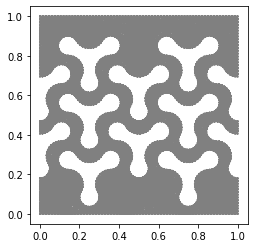

In [7]:
# load mesh
mesh = Mesh()
with XDMFFile(meshpath+meshfile) as xdmf_infile:
    xdmf_infile.read(mesh)
n_elements = mesh.coordinates().shape[0]
print(str(n_elements)+" elements in mesh")
plot(mesh)

plt.savefig(meshpath+meshfile+'.png', dpi=96, bbox_inches='tight')

### Constitutive relation

In [8]:
def sigmoid(x):
    s = 1/(1+exp(-x))
    return s
def tanh(x):
    t = (exp(2*x)-1)/(exp(2*x)+1)
    return t

In [9]:
# Constitutive relation
MODELS = ['1-tanhplastic',
          '2-perfectplasticity'
         ]
try:
    if not(constitutive_model in MODELS):
        raise NameError("UnknownModel : '{}' is not defined in MODELS".format(constitutive_model))
    else:
        print(constitutive_model)
except NameError:
    raise NameError("ModelNotDefined : constitutive_model variable is not defined")

E = Constant(E_float)
nu = Constant(nu_float)
sigma_y0 = Constant(sigma_y0_float)
mu = E/2/(1+nu)
lmbda = E*nu/(1+nu)/(1-2*nu)
lmbda = 2*mu*lmbda/(lmbda+2*mu)    

if constitutive_model=='1-tanhplastic':
    try:
        filename.split('/res')[0]+=" -- sp={} , amp={}".format(sp,amp)+"/res"
    except NameError:
        raise NameError("ModelParamNotDefined : you need to define sp and amp. Default would be amp=0.1 and sp=10.")

def epsilon(u):
    return sym(grad(u))

def sigma_el(epsilon):
    return lmbda*tr(epsilon)*Identity(2) + 2*mu*epsilon

def sigma_yield(epsilon):
    if constitutive_model == '1-tanhplastic':
        return sigma_y0 + amp*sigma_y0*tanh(epsilon*sp)
    if constitutive_model == '2-perfectplasticity':
        return sigma_y0

def epsilon_pl(d_epsilon, sigma_old, epsilon_old,kappa_value=100):
    '''
    inputs
    d_epsilon: strain increment
    sigma_old: stress tensor at the increment n
    epsilon_old: plastic strain tensor
    kappa_value: sharpness of the sigmoid function
    '''
    kappa = Constant(kappa_value)
    
    sigma_y = sigma_yield(epsilon_old)
    H = diff(sigma_y, epsilon_old)
    
    sigma_pr = sigma_old + sigma_el(d_epsilon) # trial stress
    sigma_pr_dev = dev(sigma_pr) # deviatoric elastic stress
    sigma_ef = sqrt(3/2.*inner(sigma_pr_dev, sigma_pr_dev) + DOLFIN_EPS) # effective von Mises stress
    
    sgn = (sigma_ef - sigma_y)/(abs(sigma_ef - sigma_y) + DOLFIN_EPS)
    f_sigmoid = sigmoid(kappa*(sigma_ef - sigma_y)*sgn) # the indicator function
    f_ind = (f_sigmoid-0.5)*sgn + 0.5
    
    d_epsilon_pl_sc = f_ind*(sigma_ef - sigma_y)/(3*mu + H) # plastic strain increment (scalar)
    n_pr = dev(sigma_pr) / sigma_ef
    d_epsilon_pl = d_epsilon_pl_sc*3/2*n_pr
    
    return d_epsilon_pl

def Constitutive_function(sig_n, du, ep_n, dt=1E-3):
    d_epsilon_el = epsilon(du) # elastic strain increment
    d_epsilon_pl = epsilon_pl(d_epsilon_el,sig_n,ep_n) # plastic strain increment
    d_epsilon = d_epsilon_el - d_epsilon_pl
    dot_p = sqrt(inner(d_epsilon_pl,d_epsilon_pl)*2.0/3.0 + DOLFIN_EPS) #Accumulated plastic strain rate
    return sig_n + sigma_el(d_epsilon), dot_p

1-tanhplastic


In [10]:
def mis_ep(u):
    eps_dev = epsilon(u) - Identity(2)*tr(epsilon(u))
    mis = sqrt(3/2*inner(eps_dev,eps_dev))
    return mis

def mis_sig(sig):
    sigma_dev = sig - Identity(2)*tr(sig)
    mis = sqrt(3/2*inner(sigma_dev,sigma_dev))
    return mis

In [11]:
threshold = rel_thresh*sigma_y0_float**2

In [12]:
def solve_plastic_system_and_score(mesh, Dn,Tn, constitutive_func, loss_func=lambda n,x: 0,
                         tol = 1.0E-14, filepath="./resultstester_GAP/",THR=threshold,N_seg=200):
        
    if len(Dn)!=len(Tn) : raise NameError("ProfileListsNotSameLen")
    num_stps=len(Dn)
    
    # Define function space for displacement
    S = FunctionSpace(mesh, 'P', 1)
    V = VectorFunctionSpace(mesh, 'P', 1)
    T = TensorFunctionSpace(mesh, 'P', 1)
    
    # Define test functions
    v  = TestFunction(V)
    du = TrialFunction(V)
    
    # Define functions for dsiplacement
    u     = Function(V)
    u_n   = Function(V)
    sig   = Function(T)
    sig_n = Function(T)
    ep    = Function(S)
    ep_n  = Function(S)

    # Define boundary 
    def BC_y0(x, on_boundary):
        return on_boundary and near(x[1], 0, 1e-3)
    def BC_y1(x, on_boundary):
        return on_boundary and near(x[1], 1, 1e-3)
    bcD = DirichletBC(V.sub(1), 0,    BC_y0)
    def BC_corner(x, on_boundary):
        return near(x[1], 0, tol) and near(x[0], 0, 2e-2)
    bc_corner = DirichletBC(V.sub(0), 0,    BC_corner)
    
    
    # Time-stepping
    t = Tn[0]
    results = []
    
    File_displacement = File(filepath+'displacement_AG.pvd')
    File_stress_Mis = File(filepath+'stress_Mis_AG.pvd')
    File_strain_Mis = File(filepath+'strain_Mis_AG.pvd')
    File_strain_AG = File(filepath+'strain_AG.pvd')
    File_stess_AG = File(filepath+'stess_AG.pvd')
    
    array_u = np.zeros((n_elements,2,num_stps+1))
    array_sigma = np.zeros((n_elements,2,2,num_stps+1))
    array_epsilon = np.zeros((n_elements,2,2,num_stps+1))
    
    for n in tqdm(range(num_stps)):
        print(n)
        displacement = Dn[n]
        bcU = DirichletBC(V.sub(1), displacement, BC_y1)
        BC = [bcU, bcD, bc_corner]
        
        # Define variational problem
        if n==0:
            dt=0
        if n>0:
            dt=Tn[n]-Tn[n-1]
        sig, dep = constitutive_func(sig_n, u-u_n, ep_n, dt=dt)
        F = inner(sig, epsilon(v))*dx
        
        # Update current time
        t = Tn[n]
        
        # Solve variational problem for time step
        J = derivative(F, u, du)
        problem = NonlinearVariationalProblem(F, u, BC, J)
        solver = NonlinearVariationalSolver(problem)
        solver.solve()
        
        # Update previous solution
        sig = project(sig, T)
        ep = project(ep_n+dep, S)
        
        sig_n.assign(sig)
        u_n.assign(u)
        ep_n.assign(ep)
        print('end')
        
        # Save solution to file in VTK format
        sig_Mis = project(mis_sig(sig),S)
        ep_Mis = project(mis_ep(u),S)
#         sig_Mis = mis_sig(sig)
#         ep_Mis = mis_ep(u)
        epsilon_u = epsilon(u)
        
        u.rename('$u$','displacement')
        sig.rename('$\sigma$','stress')
        ep.rename('$\epsilon$','strain')
        sig_Mis.rename('$\sigma_{VM}$','stress_Mis')
        ep_Mis.rename('$\epsilon_{VM}$','strain_Mis')
        
        File_displacement << (u,t)
        File_stress_Mis << (sig_Mis,t)
        File_strain_Mis << (ep_Mis,t)
        File_strain_AG << (ep,t)
        File_stess_AG << (sig,t)
        
        # Save element vectors in .mat format
        from scipy.io import savemat
        array_u[:,:,n] = np.array(u.vector()).reshape(n_elements,2)
        
        epsilon_u = epsilon(u)
        epsilon_u = project(epsilon(u),T)
        array_epsilon[:,:,:,n] = np.array(epsilon_u.vector()).reshape(n_elements,2,2)
        
        array_sigma[:,:,:,n] = np.array(sig.vector()).reshape(n_elements,2,2)
        
        plot(sig_Mis, mode='color')
        plt.title("Equivalent Von Mises stress in the sample at step {}".format(n))
        plt.show()
        
    PTSSTRESS=[]
    for n in range(n_elements):
        for st in range(num_stps+1):
            PTSSTRESS+=[[(array_sigma[n,0,0,st]-array_sigma[n,1,1,st])/2,array_sigma[n,0,1,st]]]
    
    mdic = {'u':array_u, 'epsilon':array_epsilon, 'sigma':array_sigma}
    savemat(filepath+'data.mat', mdic)
    
#     beep_pos()
    
    S = FunctionSpace(mesh, 'P', 2)
    sigma_Mis = project(mis_sig(sig),S)
    plot(sig_Mis, mode='color')
    plt.title("Equivalent Von Mises stress in the sample")
    plt.show()
    
    PTSSTRESS = np.array(PTSSTRESS)
    plt.plot(PTSSTRESS[:,0],PTSSTRESS[:,1],marker='o',markersize=0.3,linewidth=0)
    plt.title("Stress paths")
    plt.show()
    
    PTSSTRESS_yield=[]
    for X in PTSSTRESS:
        if X[0]**2+X[1]**2>=THR:
            PTSSTRESS_yield+=[X]
    PTSSTRESS_yield=np.vstack(PTSSTRESS_yield)
    print("nb_annular_points : "+str(len(PTSSTRESS_yield)))
    Score=GapScore(PTSSTRESS_yield,threshold=0.85,tol=1e-14)
    plt.plot(PTSSTRESS_yield[:,0],PTSSTRESS_yield[:,1],marker='o',markersize=0.3,linewidth=0)
    plt.title("Stress paths : anisotropy score = "+str(Score)[0:7])
    plt.show()
    
    
    return ep, sig, u, sig_Mis, ep_Mis, PTSSTRESS, Score

  0%|          | 0/15 [00:00<?, ?it/s]

0
end


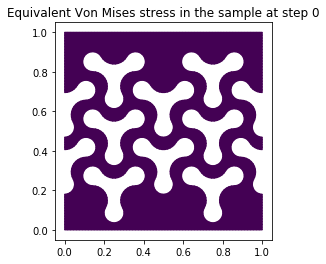

  7%|▋         | 1/15 [00:04<00:58,  4.19s/it]

1
end


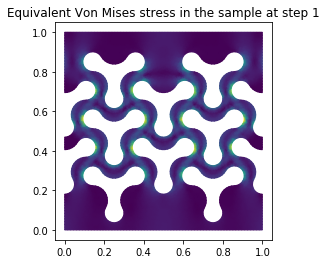

 13%|█▎        | 2/15 [00:13<01:32,  7.15s/it]

2
end


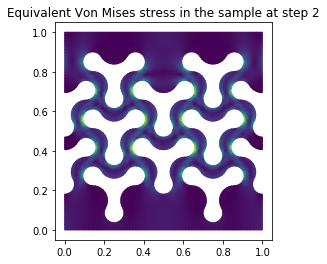

 20%|██        | 3/15 [00:22<01:35,  8.00s/it]

3
end


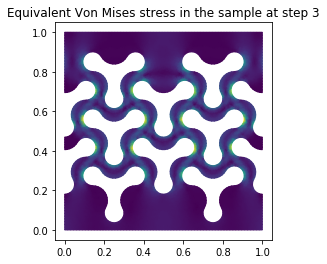

 27%|██▋       | 4/15 [00:31<01:32,  8.37s/it]

4
end


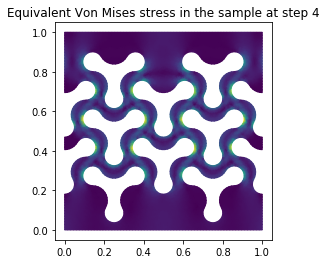

 33%|███▎      | 5/15 [00:54<02:18, 13.85s/it]

5
end


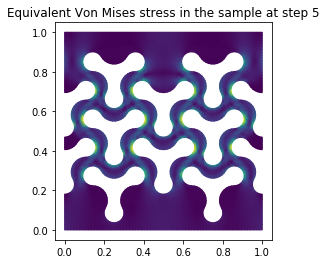

 40%|████      | 6/15 [01:23<02:50, 18.94s/it]

6
end


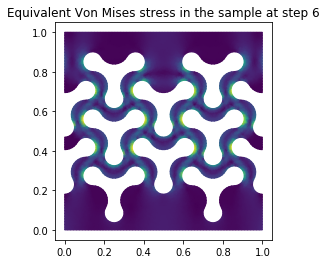

 47%|████▋     | 7/15 [01:52<02:57, 22.18s/it]

7
end


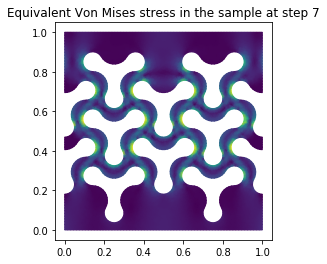

 53%|█████▎    | 8/15 [02:22<02:51, 24.54s/it]

8
end


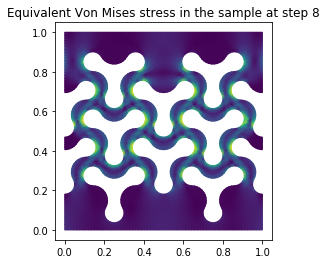

 60%|██████    | 9/15 [02:52<02:38, 26.41s/it]

9
end


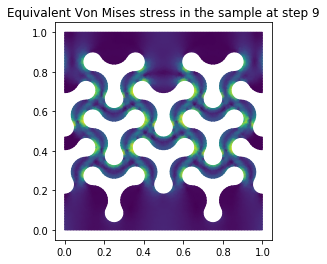

 67%|██████▋   | 10/15 [03:23<02:18, 27.68s/it]

10
end


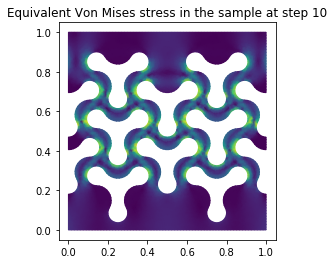

 73%|███████▎  | 11/15 [03:53<01:53, 28.41s/it]

11
end


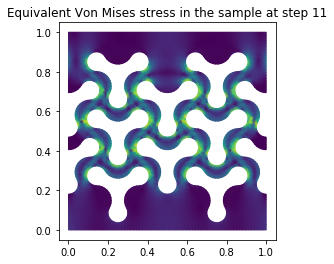

 80%|████████  | 12/15 [04:23<01:27, 29.02s/it]

12
end


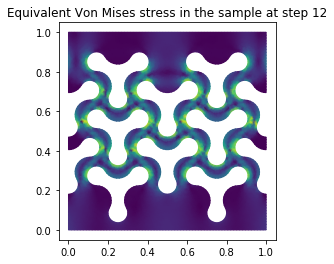

 87%|████████▋ | 13/15 [04:53<00:58, 29.23s/it]

13
end


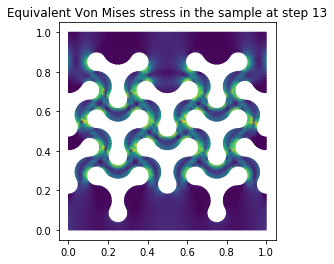

 93%|█████████▎| 14/15 [05:21<00:29, 29.01s/it]

14
end


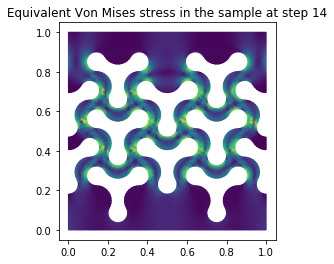

100%|██████████| 15/15 [05:50<00:00, 23.36s/it]


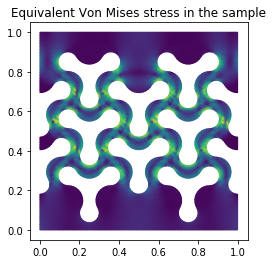

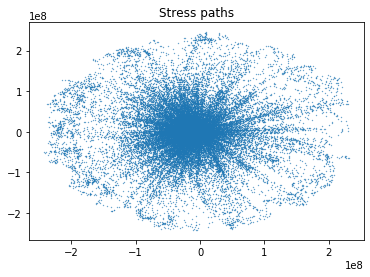

nb_annular_points : 2045


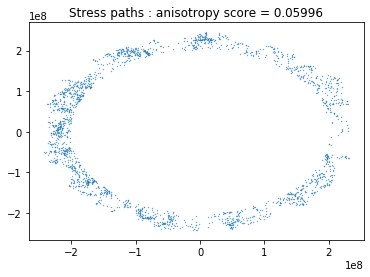

In [13]:
Dn_test=list(np.linspace(0,e_max*sample_height,nb_steps))
Tn_test=list(np.linspace(0,T_max,nb_steps))

ep, sig, u, sig_Mis, ep_Mis, PTSSTRESS, Score = solve_plastic_system_and_score(mesh, Dn_test,Tn_test, Constitutive_function, THR=threshold, filepath='./resultstester_GAP/'+meshfile+'/')
Score_stress = Score

## Evaluate strain diversity

In [14]:
def anisotropy_score_density(Stress_points,n_segments=60):
    PTSCOUNT=np.zeros(n_segments)
    div=2*np.pi/n_segments
    for [x,y] in Stress_points:
        if x==0 and y==0:
            continue
        else :
            theta=np.arctan2(y,x)
        PTSCOUNT[int(theta//div)]+=1
    # X=[div*k for k in range(n_segments)]
    n_mean=np.mean(PTSCOUNT)
#     plt.plot(X,PTSCOUNT,marker='+')
#     plt.title("$n(\Theta)$")
#     plt.plot(X,[n_mean]*n_segments,color='r')
#     plt.show()
    print(n_segments)
    Sigma=1/len(Stress_points)*np.sqrt((np.sum((PTSCOUNT-n_mean)**2))/(1-1/n_segments))
    return Sigma

def anisotropy_score_radius(Stress_points,n_segments=60):
    PTSCOUNT=np.zeros(n_segments)
    RADICOUNT=np.zeros(n_segments)
    div=2*np.pi/n_segments
    for [x,y] in Stress_points:
        if x==0 and y==0:
            continue
        else :
            theta=np.arctan2(y,x)
        PTSCOUNT[int(theta//div)]+=1
        RADICOUNT[int(theta//div)]+=np.sqrt(x**2+y**2)
    n_mean=np.mean(PTSCOUNT)
    print(n_segments)
    
    MEANRADS=RADICOUNT/PTSCOUNT
    MEANRADS/=np.max(MEANRADS)
    r_mean=np.mean(MEANRADS)
    RadiusScore=np.sqrt((np.sum((MEANRADS-r_mean)**2))/(1-1/n_segments))
    
    return RadiusScore

def anisotropy_score_harmonics(Stress_points,n_segments=60):
    PTSCOUNT=np.zeros(n_segments)
    div=2*np.pi/n_segments
    for [x,y] in Stress_points:
        if x==0 and y==0:
            continue
        else :
            theta=np.arctan2(y,x)
        PTSCOUNT[int(theta//div)]+=1
    n_mean=np.mean(PTSCOUNT)
    
    rho = (PTSCOUNT-n_mean)/len(Stress_points)
    theta = np.arange(n_segments)*div
    f_cos = np.sum(np.cos(theta)*rho)
    f_sin = np.sum(np.sin(theta)*rho)
    
    score = f_cos**2 + f_sin**2
    return score

### load data

In [15]:
from scipy.io import loadmat
filename = './resultstester_GAP/'+meshfile+'/'+'data.mat'
epsilon = loadmat(filename)['epsilon']
n_element = epsilon.shape[0]

### Calculate anisotropic score

In [16]:
n_frame = epsilon.shape[3]
strain = np.arange(n_frame)/(n_frame-1)*e_max

epsilon_normal = np.zeros((n_element,n_frame))
epsilon_shear = np.zeros((n_element,n_frame))

In [17]:
for it in tqdm(range(n_frame)):
    epsilon_t = epsilon[:,:,:,it].reshape(n_element,4)
    
    epsilon_normal[:,it] = (epsilon_t[:,0] - epsilon_t[:,3])/2
    epsilon_shear[:,it] = epsilon_t[:,2]

epsilon_radius2 = (epsilon_normal**2 + epsilon_shear**2).reshape(n_frame*n_element).tolist()
epsilon_all = np.vstack((epsilon_normal.reshape(n_frame*n_element),epsilon_shear.reshape(n_frame*n_element))).T.tolist()

Score_strain_density = anisotropy_score_density(epsilon_all,n_segments=60)
Score_strain_radius = anisotropy_score_radius(epsilon_all,n_segments=60)
Score_strain_harmonics = anisotropy_score_harmonics(epsilon_all,n_segments=60)
print('Score_strain_density = {}'.format(Score_strain_density))
print('Score_strain_radius = {}'.format(Score_strain_radius))
print('Score_strain_harmonics = {}'.format(Score_strain_harmonics))

100%|██████████| 16/16 [00:00<00:00, 5722.11it/s]


60
60
Score_strain_density = 0.08856712299926117
Score_strain_radius = 1.274286262103572
Score_strain_harmonics = 0.11604961421121232


### Plot the result

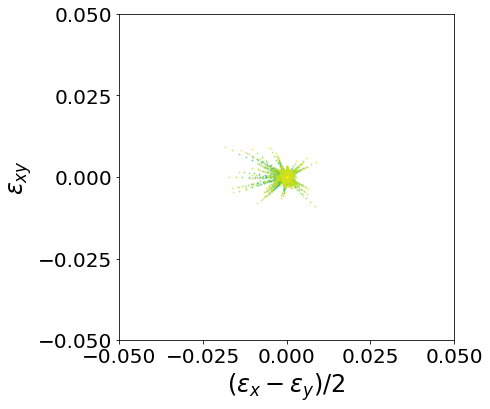

In [18]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(epsilon_normal[:,it],epsilon_shear[:,it],'.',color=colors[it],alpha=0.5,markersize=2)
    
# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-.025, .025)
ax.set_ylim(-.025, .025)
ax.set_xticks(np.array([-1e-1, -5e-2, 0, 5e-2, 1e-1])/2)
ax.set_yticks(np.array([-1e-1, -5e-2, 0, 5e-2, 1e-1])/2)
ax.set_xlabel('$(\epsilon_x - \epsilon_y)/2$',fontsize=24)
ax.set_ylabel('$\epsilon_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

## Evaluate stress diversity

### load data

In [19]:
from scipy.io import loadmat
filename = './resultstester_Gap/'+meshfile+'/'+'data.mat'
sigma = loadmat(filename)['sigma']
n_element = sigma.shape[0]

### Calculate anisotropic score

In [20]:
n_frame = sigma.shape[3]
strain = np.arange(n_frame)/(n_frame-1)*e_max

sigma_normal = np.zeros((n_element,n_frame))
sigma_shear = np.zeros((n_element,n_frame))

In [21]:
for it in tqdm(range(n_frame)):
    sigma_t = sigma[:,:,:,it].reshape(n_element,4)
    
    sigma_normal[:,it] = (sigma_t[:,0] - sigma_t[:,3])/2
    sigma_shear[:,it] = sigma_t[:,2]

sigma_radius2 = (sigma_normal**2 + sigma_shear**2).reshape(n_frame*n_element).tolist()
sigma_all = np.vstack((sigma_normal.reshape(n_frame*n_element),sigma_shear.reshape(n_frame*n_element))).T.tolist()
sigma_annular = [x for x in sigma_all if x[0]**2+x[1]**2>threshold]
Score_stress_density = anisotropy_score_density(sigma_annular,n_segments=60)
Score_stress_radius = anisotropy_score_radius(sigma_annular,n_segments=60)
Score_stress_harmonics = anisotropy_score_harmonics(sigma_annular,n_segments=60)
print('Score_stress_density = {}'.format(Score_stress_density))
print('Score_stress_radius = {}'.format(Score_stress_radius))
print('Score_stress_harmonics = {}'.format(Score_stress_harmonics))

100%|██████████| 16/16 [00:00<00:00, 6811.01it/s]

60
60
Score_stress_density = 0.07458506767179021
Score_stress_radius = 0.16910428602574124
Score_stress_harmonics = 0.04439206105712076


### Plot the result

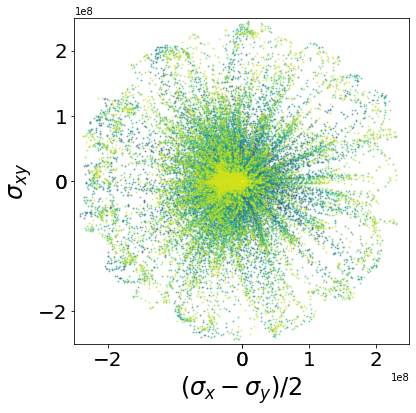

In [22]:
from matplotlib import cm
fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

colors = cm.viridis(np.linspace(0, 1, n_frame))

for it in range(n_frame):
    ax.plot(sigma_normal[:,it],sigma_shear[:,it],'.',color=colors[it],alpha=0.5,markersize=2)
    
# print('rho = {:0.4f}'.format(corr[0,1]))
    
ax.set_xlim(-2.5e8, 2.5e8)
ax.set_ylim(-2.5e8, 2.5e8)
ax.set_xticks([-2e8, -1e-8, 0, 1e8, 2e8])
ax.set_yticks([-2e8, -1e-8, 0, 1e8, 2e8])
ax.set_xlabel('$(\sigma_x - \sigma_y)/2$',fontsize=24)
ax.set_ylabel('$\sigma_{xy}$',fontsize=24)
ax.tick_params(which='both', labelsize=20)

# pngname = 'corr.png'
# plt.savefig(pngname, dpi=96, bbox_inches='tight')

In [23]:
# Score_density = np.array([Score_strain_density,Score_stress_density])
# Score_radius = np.array([Score_strain_radius,Score_stress_radius])
# Score_h = np.array([Score_strain_harmonics,Score_stress_harmonics])

# from scipy.io import savemat
# mdic = {'Score_density':Score_density,'Score_radius':Score_radius,'Score_h':Score_h}
# savemat('./resultstester/'+meshfile+'/'+'score_v2.mat', mdic)

In [24]:
Score=GapScore(sigma_all,threshold=0.85,tol=1e-14)

In [25]:
Score

0.059965448606777626